In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap

from jax import random

from jax.config import config

from jax_tqdm import loop_tqdm

from scipy.spatial import Delaunay

import functools

config.update("jax_debug_nans", True)

from functools import cache


C:\Users\jakob\AppData\Local\Temp\ipykernel_25140\3815902663.py:7: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [23]:
%matplotlib widget

G = {
    "beta": 5.0,
    "lambda0": 1.0,
    "lambda1": 0.0,
    "lambda2": 0.0,
    "dt": 0.1,
    "eta": 0.00, # width of the gaussian noise
    "orientation_mode": "vector" # "vector" or "angles"
}

@jit
def unpack_cellrow(cellrow : jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray]:
    if G["orientation_mode"] == "vector":
        pos = cellrow[0]
        p = cellrow[1]
        q = cellrow[2]
    elif G["orientation_mode"] == "angles":
        pos = cellrow[0]
        p = from_angles_to_vector(cellrow[1], cellrow[2])
        q = from_angles_to_vector(cellrow[3], cellrow[4])
    else:
        raise ValueError("orientation_mode must be either 'vector' or 'angles'")
    return pos, p, q

@jit
def quadruple(a1, a2, b1, b2) -> float: 
    return jnp.dot(jnp.cross(a1, b1), jnp.cross(a2, b2))
@jit
def V(r : float, S : float) -> float:
    return jnp.exp(-r) - S * jnp.exp(- r / G["beta"])

@jit
def S(r, p1, q1, p2, q2) -> float:
    S1 = quadruple(p1, p2, r, r)
    S2 = quadruple(p1, p2, q1, q2)
    S3 = quadruple(q1, q2, r, r)

    return G["lambda0"]*S1 + G["lambda1"]*S2 + G["lambda2"]*S3

def from_angles_to_vector(alpha, beta) -> jnp.ndarray:
    x = jnp.cos(alpha)*jnp.cos(beta)
    y = jnp.sin(alpha)*jnp.cos(beta)
    z = jnp.sin(beta)
    return jnp.array([x, y, z])

@jit
def U(cellrow1 : jnp.ndarray, cellrow2 : jnp.ndarray) -> float:
    pos1, p1, q1 = unpack_cellrow(cellrow1)
    pos2, p2, q2 = unpack_cellrow(cellrow2)

    dir = pos2 - pos1

    s = S(dir, p1, q1, p2, q2)
    
    _dir = jnp.where(jnp.allclose(dir, jnp.zeros(3)), jnp.array([1, 0, 0]), dir)

    r = jnp.linalg.norm(_dir)

    v = V(r, s)

    v_corrected = jnp.where(jnp.allclose(dir, jnp.zeros(3)), 0.0, v)

    return v_corrected


def get_IC(N : int) -> jnp.ndarray:

    # N random uniform points in 3D
    key = random.PRNGKey(42)
    pos = (random.uniform(key, (N, 3))*2 - 1)*10

    # N vectors pointing up
    # p = jnp.repeat(jnp.array([[0, 0, 1]]), N, axis=0)

    # N random angles between 0 and 2pi
    if G["orientation_mode"] == "vector":
        key = random.PRNGKey(0)
        p = random.uniform(key, (N, 3))*2 - 1
        p = p / jnp.linalg.norm(p, axis=1, keepdims=True)

        key = random.PRNGKey(1)
        q = random.uniform(key, (N, 3))*2 - 1
        q = q / jnp.linalg.norm(q, axis=1, keepdims=True)

    elif G["orientation_mode"] == "angles":
        key = random.PRNGKey(0)
        p = random.uniform(key, (N, 2))*2*jnp.pi
        p = jnp.concatenate([p, jnp.zeros((N, 1))], axis=1)
        key = random.PRNGKey(1)
        q = random.uniform(key, (N, 2))*2*jnp.pi
        q = jnp.concatenate([q, jnp.zeros((N, 1))], axis=1)

    # combine them
    assert pos.shape == p.shape == q.shape

    cells = jnp.stack([pos, p, q], axis=1)

    return cells

@cache
def find_array_that_has_own_indexes(size):
    indx = jnp.repeat(jnp.arange(size[0]), repeats = size[1]).reshape((size[0], size[1]))
    return indx

@functools.partial(jit, static_argnames=["k", "recall_target"])
def l2_ann(qy, db,  k=10, recall_target=0.95):
    half_db_norms = jnp.linalg.norm(db, axis=1)**2 / 2
    dists = half_db_norms - jax.lax.dot(qy, db.transpose())
    return jax.lax.approx_min_k(dists, k=k, recall_target=recall_target)

@functools.partial(jit, static_argnames=["k"])
def find_neighbors(cells : jnp.ndarray, k : int = 5):
    positions = cells[:,0,:]
    dists, neighbors = l2_ann(positions, positions, k=k+1)

    neighbors = neighbors[:,1:] # remove the first neighbor, which is the particle itself

    neighbor_positions = positions[neighbors]  # (N,k,3)
    
    # dx : torch tensor (N,k,3)
    #      Tensor containing vectors pointing from each potential neighbor to the particle
    dx = neighbor_positions - positions[:,None,:]


    d = jnp.linalg.norm(dx, axis=2)


    # # only find those that can interact through voronoi
    n_dis = jnp.sum((dx[:, :, None, :] / 2 - dx[:, None, :, :]) ** 2, axis=3)    # Finding distances from particle k to the midpoint between particles i and j squared for all potential neighbors
    n_dis += 1000 * jnp.eye(n_dis.shape[1])[None, :, :]                  # We add 1000 to the sites that correspond to subtracting the vector ij/2 with ij, so these don't fuck anything up.
    
    z_mask = jnp.sum(n_dis < (d[:, :, None] ** 2 / 4), axis=2) <= 0

    indx = find_array_that_has_own_indexes((neighbors.shape[0], k))
    actual_neighbors = jnp.where(z_mask, neighbors, indx)
    return actual_neighbors


# compute the energy of the system
@jit
def U_sum(cells : jnp.ndarray):
    neighbors = find_neighbors(cells, k=10)

    # empty array to hold the energies
    arr = jnp.empty((cells.shape[0], neighbors.shape[1]), float)

    def loop_fn(i, arr):
        val = jax.vmap(lambda nb: U(cells[i], nb))(cells[neighbors[i,:]])
        arr = arr.at[i,:].set(val)
        return arr
    

    arr = jax.lax.fori_loop(0, cells.shape[0], loop_fn, arr)

    final_sum = jnp.sum(arr)


    return final_sum
    # return U_total


U_grad = grad(U_sum)

@jit
def take_step(cells : jnp.ndarray):
    # print the energy using jax.debug
    # jax.debug.print(str(jax.lax.stop_gradient(U_sum(cells)).astype(float)))
    # compute the gradient of the energy
    grad_U = U_grad(cells)

    # update the positions
    cells = cells - grad_U*G["dt"] 

    # add random noise to the positions
    cells = cells.at[:,0,:].add(random.normal(random.PRNGKey(0), cells.shape[0:2])*G["eta"])

    # normalize p and q
    ns = cells[:,1:,:] / jnp.linalg.norm(cells[:,1:,:], axis=2)[:,:,None]
    cells = cells.at[:,1:,:].set(ns)
    

    # print magnitude of the cells positions

    return cells


def main(N_cells : int, N_steps : int):
    cells = get_IC(N_cells)
    # plot_cells(cells)

    @loop_tqdm(N_steps)
    def jaxstep(i, cells):
        return take_step(cells)

    cells = jax.lax.fori_loop(0, N_steps,jaxstep, cells)
    return cells


# with jax.profiler.trace("/tmp/jax-trace", create_perfetto_link=True):
cells = main(200, 1000)
    # cells.block_until_ready()

  0%|          | 0/1000 [00:00<?, ?it/s]

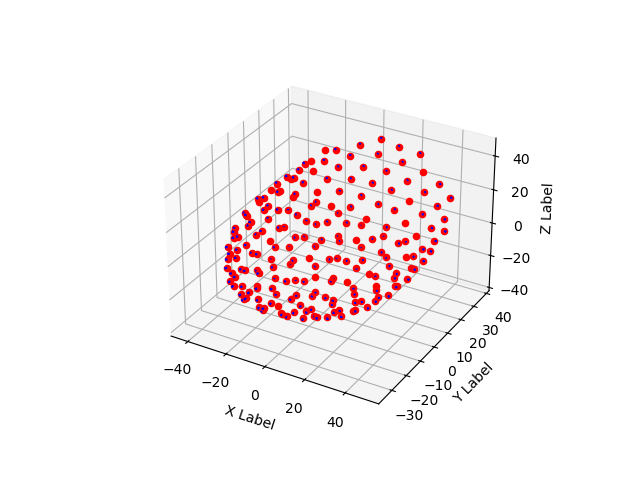

In [20]:
plot_cells(cells)

In [9]:
import matplotlib.pyplot as plt

# 3d plot of the cells
def plot_cells(cells : jnp.ndarray):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    for cell in cells:
        x, p, q = unpack_cellrow(cell)
        ax.scatter(x[0], x[1], x[2], c='r', marker='o')
        ax.quiver(x[0], x[1], x[2], p[0], p[1], p[2], length=1, normalize=True, color='blue')


    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

